# Test MCS with Linear Regression

This is a notebook for testing MCS with linear regression

## Import everything

modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch and other standard modules

In [2]:
%matplotlib inline
import torch
from torch.utils import data
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import MCS and CostFunc

In [3]:
from MCS import MCSOptimizer
from CostFunc import GradFreeMSELoss
from CostFunc import StandardSNN

## Linear Regression Testing

### Generate training data

In [4]:
def synthetic_data(w, b, num_examples):  
    """y = Xw + b + noise"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.9387, -0.4471]) 
label: tensor([3.8541])


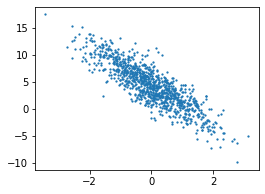

In [7]:
fig, axes = plt.subplots(1,1,figsize=(4,3))
axes.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(),s=1.5);

### Reading the data via torch API

In [8]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Generate a PyTorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [9]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [10]:
next(iter(data_iter))

[tensor([[ 0.3312, -0.9121],
         [-1.3058,  0.2278],
         [-0.2058, -0.4896],
         [ 0.9091, -0.2327],
         [-0.0031, -0.3423],
         [ 0.1485, -0.0396],
         [-0.4109, -0.5763],
         [-0.1027,  2.2382],
         [ 0.1895, -1.0077],
         [-0.0167,  0.0122]]),
 tensor([[ 7.9797],
         [ 0.8206],
         [ 5.4419],
         [ 6.8030],
         [ 5.3621],
         [ 4.6307],
         [ 5.3476],
         [-3.6196],
         [ 8.0064],
         [ 4.1262]])]

## Define a model

### Function for initialize weight function

In [11]:
def getParams(num_inputs,num_outputs):
    w=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return (w,b)

### Linear Net Model

In [12]:
class LinearNet(StandardSNN):
    '''a standard net with linear regression'''
    def __init__(self,getParams,inputSize,numHiddens):
        self.params=getParams(inputSize,numHiddens)

    def __call__(self,X:torch.Tensor):
        return self.call_with_weight(X,self.params)

    def call_with_weight(self,X:torch.Tensor,weight:tuple):
        w,b=weight
        return torch.matmul(X,w)+b

In [13]:
net=LinearNet(getParams,2,1)
print(net.params)
rawParams=()
for param in net.params:
    rawParams+=(param.clone().detach().requires_grad_(True),)
print(rawParams)

(tensor([[ 0.0048],
        [-0.0023]], requires_grad=True), tensor([0.], requires_grad=True))
(tensor([[ 0.0048],
        [-0.0023]], requires_grad=True), tensor([0.], requires_grad=True))


## Train a model

### Set epochs

In [14]:
num_epochs=5

### Loss function

In [15]:
lossFunc=GradFreeMSELoss(net,reduction='none')

### MCS optimizer

In [16]:
mcs=MCSOptimizer(net.params,lossFunc,data_iter,\
                    maxLevyStepSize=0.3,\
                    nestNum=6)

In [17]:
l_epochs_mcs=[float(lossFunc(net(features), labels).mean())]
print(f'epoch 0, loss {l_epochs_mcs[0]:f}')
for epoch in range(num_epochs):
    mcs.step()
    with torch.no_grad():
        train_l = lossFunc(net(features), labels)
        l_epochs_mcs.append(float(train_l.mean()))
        print(f'epoch {epoch + 1}, loss {l_epochs_mcs[epoch+1]:f}')

epoch 0, loss 34.047985
epoch 1, loss 0.018352
epoch 2, loss 0.003239
epoch 3, loss 0.001012
epoch 4, loss 0.000164
epoch 5, loss 0.000164


In [18]:
w,b=net.params
print(w,b)
print(f'loss of w: {true_w - w.reshape(true_w.shape)}')
print(f'loss of b: {true_b - b}')

tensor([[ 1.9969],
        [-3.3996]], requires_grad=True) tensor([4.2076], requires_grad=True)
loss of w: tensor([ 0.0031, -0.0004], grad_fn=<SubBackward0>)
loss of b: tensor([-0.0076], grad_fn=<RsubBackward1>)


### Standard sgd

In [19]:
net.params=rawParams
print(net.params)

(tensor([[ 0.0048],
        [-0.0023]], requires_grad=True), tensor([0.], requires_grad=True))


In [21]:
def sgd(params, lr, batch_size):  
    """sgd"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [22]:
lr = 0.03

In [23]:
l_epochs_sgd=[]
l_epochs_sgd=[float(lossFunc(net(features), labels).mean())]
print(f'epoch 0, loss {l_epochs_sgd[0]:f}')
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = lossFunc(net(X), y)
        l.sum().backward()
        sgd(net.params, lr, batch_size) 
    with torch.no_grad():
        train_l = lossFunc(net(features), labels)
        l_epochs_sgd.append(float(train_l.mean()))
        print(f'epoch {epoch + 1}, loss {l_epochs_sgd[epoch+1]:f}')

epoch 0, loss 34.047985
epoch 1, loss 0.000187
epoch 2, loss 0.000096
epoch 3, loss 0.000096
epoch 4, loss 0.000096
epoch 5, loss 0.000096


In [24]:
w,b=net.params
print(w,b)
print(f'loss of w: {true_w - w.reshape(true_w.shape)}')
print(f'loss of b: {true_b - b}')

tensor([[ 2.0004],
        [-3.4000]], requires_grad=True) tensor([4.2005], requires_grad=True)
loss of w: tensor([-4.2057e-04,  4.3154e-05], grad_fn=<SubBackward0>)
loss of b: tensor([-0.0005], grad_fn=<RsubBackward1>)


## Visualize the Result

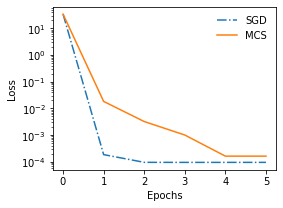

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(4,3))

axes.semilogy(range(0,num_epochs+1),l_epochs_sgd,linestyle='-.',label='SGD')
axes.semilogy(range(0,num_epochs+1),l_epochs_mcs,linestyle='-',label='MCS')


axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')

axes.xaxis.set_major_formatter(FormatStrFormatter('%d'))

axes.legend(loc=0,frameon=False);